Source: https://towardsdatascience.com/multi-class-classification-with-transformers-6cf7b59a033a

Notebook: https://github.com/jamescalam/transformers/tree/main/course/project_build_tf_sentiment_model

In [1]:
#Importing data

import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


# ***Preparing Data***

We will start by reading the data into a Pandas Dataframe using the read_csv function. Because we're working with .tsv (tab seperate values) files we need to specify that we will be taking tab characters as the delimiters:

In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/TFM - ATRIBUS/train.tsv', sep='\t')
df.head()

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,sadness
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,joy
2,3,Amo a Arya Stark por encima de todas las cosas...,joy
3,4,Gracias HASHTAG es increíble que una niña logr...,others
4,5,Solo siento que hayamos perdido 24 escaños de ...,sadness


In [3]:
df = df.rename({'label ': 'label'}, axis=1) #Rename the column label
df = df[~df.label.str.contains("others")]
df = df[~df.label.str.contains("disgust")]

In [4]:
label_map = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}
df['label'] = df['label'].map(label_map)
df

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,1
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,0
2,3,Amo a Arya Stark por encima de todas las cosas...,0
4,5,Solo siento que hayamos perdido 24 escaños de ...,1
5,6,Solo con ver con la intensidad que agitan las ...,0
...,...,...,...
5879,5880,IMPOSIBLE DE VER: Melisandre podría estar ya e...,3
5882,5883,¿Sabías que de las dos coronaciones que se cel...,3
5883,5884,Mientras reflexionamos sobre lo duro que es es...,2
5884,5885,La fachada de la catedral de Notre Dame fue “s...,1


Let's check the distribution of sentiment classes across our data.

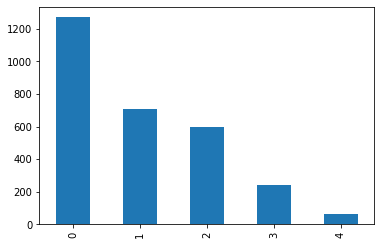

In [5]:
df['label'].value_counts().plot(kind='bar')

We will be tokenizing this text to create two input tensors; our input IDs, and attention mask.

We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.

In [6]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(2884, 512)

Now we can begin tokenizing with a BertTokenizer, like so:

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 76.3 MB/s 
     |████████████████████████████████| 120 kB 94.9 MB/s 


In [8]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['tweet'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Which returns us three numpy arrays - input_ids, token_type_ids, and attention_mask.

In [9]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [10]:
tokens['input_ids'][:10]

array([[  101,  2896, 18034, ...,     0,     0,     0],
       [  101,  2499,  1197, ...,     0,     0,     0],
       [  101,  7277,  1186, ...,     0,     0,     0],
       ...,
       [  101, 24258,   181, ...,     0,     0,     0],
       [  101,   200,  2001, ...,     0,     0,     0],
       [  101,   151, 27648, ...,     0,     0,     0]])

In [11]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

And now we save them to file as Numpy binary files:

In [12]:
with open('tweet-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('tweet-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

Now that we have them on file, we can delete the in-memory arrays to free up memory.

In [13]:
del tokens

Our input tensors are prepared, but we haven't touched our target data yet. So, let's move onto that.

Presently our target data is a set of integer values (representing sentiment classes) in the Sentiment column of our dataframe df. We need to extract these values and one-hot encode them into another numpy array, which will have the dimensions len(df) * number of label classes. Again, we will initialize a numpy zero array beforehand, but we won't populate it row by row - we will use some fancy indexing techniques instea

In [14]:
# first extract sentiment column
arr = df['label'].values

In [15]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(2884, 5)

We are able to use arr.max()+1 to define our second dimension here because we have the values [0, 1, 2, 3, 4] in our Sentiment column, there are five unique labels which means we need our labels array to have five columns (one for each) - arr.max() = 4, so we do 4 + 1 to get our required value of 5.

Now we use the current values in our arr of [0, 1, 2, 3, 4] to place 1 values in the correct positions of our presently zeros-only array:

In [16]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

And there is our one-hot encoded labels array. Just like before, we save this to file as a Numpy binary file.

In [17]:
with open('tweet-labels.npy', 'wb') as f:
    np.save(f, labels)

# ***Input Pipeline***

As we're using TensorFlow we can make use of the tf.data.Dataset object. First, we'll load in our Numpy binaries from file:

In [18]:
import numpy as np

with open('tweet-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('tweet-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('tweet-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

We can take these three arrays and create a TF dataset object with them using from_tensor_slices like so:

In [19]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Each sample in our dataset is a tuple containing a single Xids, Xmask, and labels tensor. However, when feeding data into our model we need a two-item tuple in the format (\<inputs>, \<outputs>). Now, we have two tensors for our inputs - so, what we do is enter our \<inputs> tensor as a dictionary:

{
    'input_ids': <input_id_tensor>,
    'attention_mask': <mask_tensor>
}

To rearrange the dataset format we can map a function that modifies the format like so:

In [20]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Now we can see that our dataset sample format has been changed. Next, we need to shuffle our data, and batch it. We will take batch sizes of 16 and drop any samples that don't fit evenly into chunks of 16.

In [21]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

Now our dataset samples are organized into batches of 16. The final step is to split our data into training and validation sets. For this we use the take and skip methods, creating and 70-30 split.

In [22]:
split = 0.7

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

126

In [23]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

Our two datasets are fully prepared for our model inputs. Now, we can save both to file using tf.data.experimental.save.

In [24]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

Now we will be loading these files using tf.data.experimental.load. Which requires us to define the tensor element_spec - which describes the tensor shape. To find our dataset element spec we can write:

In [25]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [26]:
val_ds.element_spec == train_ds.element_spec

True

We will be using this tuple when loading our data in the next notebook.

In [27]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

# ***Build and Train***

Now we're ready to begin building our sentiment classifier and begin training. We will be building out what is essentially a frame around Bert, that will allow us to perform language classification. First, we can initialize the Bert model, which we will load as a pretrained model from transformers.

In [28]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


Now we need to define the frame around Bert, we need:



*   Two input layers (one for input IDs and one for attention mask).
*   A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.
*   Max pooling layer to convert the 3D tensors output by Bert to 2D.
*   Final output activations using softmax for outputting categorical probabilities.










In [29]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

We can now define our model, specifying input and output layers. Finally, we can freeze the Bert layer because Bert is already highly trained, and contains a huge number of parameters so will take a very long time to train further. Nonetheless, if you'd like to train Bert too, there is nothing wrong with doing so.

In [30]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
#model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

Our model architecture is now setup, and we can initialize our training parameters like so:

In [31]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

Now all we need to do is train our model. For this, we need to load in our training and validation datasets - which also requires our dataset element specs to be defined.

In [32]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

And now we train our model as usual.

In [35]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
126/126 [==============================] - 1531s 12s/step - loss: 1.1936 - accuracy: 0.5174 - val_loss: 1.0588 - val_accuracy: 0.5880
Epoch 2/3
126/126 [==============================] - 1484s 12s/step - loss: 0.9727 - accuracy: 0.6354 - val_loss: 0.8554 - val_accuracy: 0.6759
Epoch 3/3
126/126 [==============================] - 1448s 12s/step - loss: 0.7683 - accuracy: 0.7316 - val_loss: 0.7319 - val_accuracy: 0.7500


In [36]:
model.save('sentiment_model')

# ***Load and Predict***

We've now built our model, trained it, and saved it to file - now we can begin applying it to making predictions. First, we load the model with tf.keras.models.load_model.

In [43]:
import tensorflow as tf

model = tf.keras.models.load_model('sentiment_model')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

Before making our predictions we need to format our data, which requires two steps:

Tokenizing the data using the bert-base-cased tokenizer.

Transforming the data into a dictionary containing 'input_ids' and 'attention_mask' tensors.

In [44]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [45]:
probs = model.predict(prep_data("hello world"))[0]

probs

array([0.77039576, 0.01841323, 0.02865833, 0.16385314, 0.01867959],
      dtype=float32)

In [46]:
import numpy as np

np.argmax(probs)

0

So we have made a test prediction, but we want to be applying this to real phrases from test.tsv. We will load the data into a dataframe, remove fragment duplicates based on SentenceId, then iterate through the list and create a new sentiment column.

In [47]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('/content/drive/MyDrive/TFM - ATRIBUS/test_task2.tsv', sep='\t')
df.head()

,id,tweet
0,1,"El 26 de octubre de 2018 grabé este vídeo durante mi primer viaje a HASHTAG. Las campanas de la Catedral de HASHTAG se escuchaban por toda la ciudad. Fue un momento mágico. Hoy, el mundo entero llora por una gran pérdida. Mi corazón se une al dolor de HASHTAG. Terrible 😔⛪️🇫🇷 URL"
1,2,"Se incendió HASHTAG en USER pese a todas las medidas de seguridad y nunca le ocurrió nada a la Iglesia de las Nieves en Bogotá, cuando funcionaba dentro de ella un asadero de pollos. Son las paradojas de la vida. 😂🤣 URL"
2,3,Me da tristeza saber que fue incendiado y todavía no le he ido a conocer 🥺 HASHTAG URL
3,4,"Hoy es un día triste en HASHTAG HASHTAG catedral de nuestra señora es muy hermosa, cuando este reconstruida va a estar más hermosa que antes."
4,5,¿Cómo pudo pasar algo así HASHTAG? Una verdadera tragedia.


Now we initialize our new sentiment column, and begin making predictions

In [48]:
df['label'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['tweet'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'label'] = pred

df.head()

,id,tweet,label
0,1,"El 26 de octubre de 2018 grabé este vídeo durante mi primer viaje a HASHTAG. Las campanas de la Catedral de HASHTAG se escuchaban por toda la ciudad. Fue un momento mágico. Hoy, el mundo entero llora por una gran pérdida. Mi corazón se une al dolor de HASHTAG. Terrible 😔⛪️🇫🇷 URL",1
1,2,"Se incendió HASHTAG en USER pese a todas las medidas de seguridad y nunca le ocurrió nada a la Iglesia de las Nieves en Bogotá, cuando funcionaba dentro de ella un asadero de pollos. Son las paradojas de la vida. 😂🤣 URL",1
2,3,Me da tristeza saber que fue incendiado y todavía no le he ido a conocer 🥺 HASHTAG URL,1
3,4,"Hoy es un día triste en HASHTAG HASHTAG catedral de nuestra señora es muy hermosa, cuando este reconstruida va a estar más hermosa que antes.",1
4,5,¿Cómo pudo pasar algo así HASHTAG? Una verdadera tragedia.,1


In [49]:
df.tail()

,id,tweet,label
1648,1661,"Se han dado cuenta que todos esos mentirosos corruptos de USER USER y demases, predican del alto a la violencia en HASHTAG pero a la vez apoyan un HASHTAG en HASHTAG en donde van a desaparecer y morir personas, como en Chile del '73",2
1649,1662,"USER USER Pocas cosas son tan imbéciles como la izquierda argentina! Hippies con OSDE que se cagan en las verdaderas víctimas y tienen el tupé de querer explicarle a ellos, los venezolanos, qué pasa en HASHTAG!!! Son 🐒, allá atrás en la escala zoológica...",2
1650,1663,"Es imposible describir lo que se vive en HASHTAG,Los amigos de Mujica y Tabaré Vázquez y de todo el F. A atropellando civiles con tanquetas. Esto es la dictadura asesina de Nicolás Maduro. URL",2
1651,1664,Dembele de mierda piernas chuecas regalaste dos goles HASHTAG barcelona habría ganado 5 a 0 joder,2
1652,1665,HASHTAG Puta q son desagradables los wnes del Barca en especial Lucho Suarez wm! HASHTAG HASHTAG HASHTAG,0
